# Adelie Penguin - Present Day access and colonies
- Plot AP colony distances on CESM grid with typical polynyas and colony locations+size
- Needs to load files of AP colony distance and population
- Notebook by Alice DuVivier (NCAR)
- October 2024

In [1]:
import utils
import pandas as pd
import xarray as xr
import numpy as np
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd

## Read in penguin data

In [2]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

### Read penguin colony location/population info

In [3]:
# Read in AP colony data 
file_in = 'CESM_grid_Adelie_colony_present_day.nc'
ds_ap_col= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [4]:
# get colony population info for plotting
data_col_pop = ds_ap_col.colony_pop
data_col_lat = ds_ap_col.colony_lat
data_col_lon = ds_ap_col.colony_lon

### Read penguin accessibility data

In [5]:
# Read in AP data 
file_in = 'CESM_grid_Adelie_individual_access_present_day.nc'
ds_ap= xr.open_mfdataset(dir_in+file_in,decode_times=False)

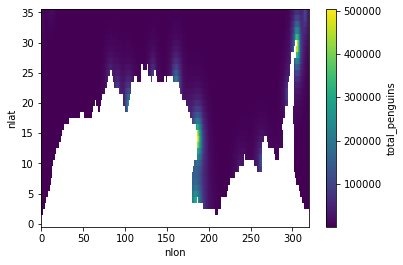

In [6]:
# sum over all colonies
total_penguins = ds_ap.total_penguins
total_penguins.plot()

### Load regional mask data and shapefiles

In [7]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [8]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [9]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [10]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [11]:
lons = ds_ap.TLONG
lats = ds_ap.TLAT

### Set plotting ranges, etc.

In [12]:
# maximum individuals at a point
total_penguins.max(dim=['nlat','nlon']).values

array(503963.0771668)

In [13]:
# set some plotting info
cmap_in = cmocean.cm.dense
vmin_in = 0.0
vmax_in = 300000.0
levels_in_poly = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)
units = '# Adelie Penguins'
title = 'Adelie Penguin access to each grid point'

In [14]:
# set circle areas for colonies
# loop through each colony population and set it based on 5 bins
# 1 --> population values of 2 (too small to be measured by satellite): A = 25
# 2 --> population 0-1999: A = 50
# 3 --> population 2000-19999: A = 100
# 4 --> population 20000-999999: A = 250
# 5 --> population > 100000: A = 500

clen = len(ds_ap_col.index)
area = np.zeros([clen])

for col in np.arange(0,clen,1):
    pop = data_col_pop.isel(index=col)
    if (pop == 2):
        area[col] = 25
    elif ((pop > 2) and (pop <= 1999)):
        area[col] = 50
    elif ((pop > 2000) and (pop <= 19999)):
        area[col] = 100
    elif ((pop > 20000) and (pop <= 99999)):
        area[col] = 250
    elif (pop > 100000):
        area[col] = 500

# Set some lats/lons, etc. for a legend
lons_leg = [0,0,0,0,0]
lats_leg = [-79.0,-80.25,-81.5,-83.0,-84.5]
area_leg = [25,50,100,250,500]
text_leg = ['Unknown','<2,000','2,000-19,999','20,000-99,999','>100,000']

### Save plot

In [15]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'
fout = 'Figure_1_Adelie_access_present_day'

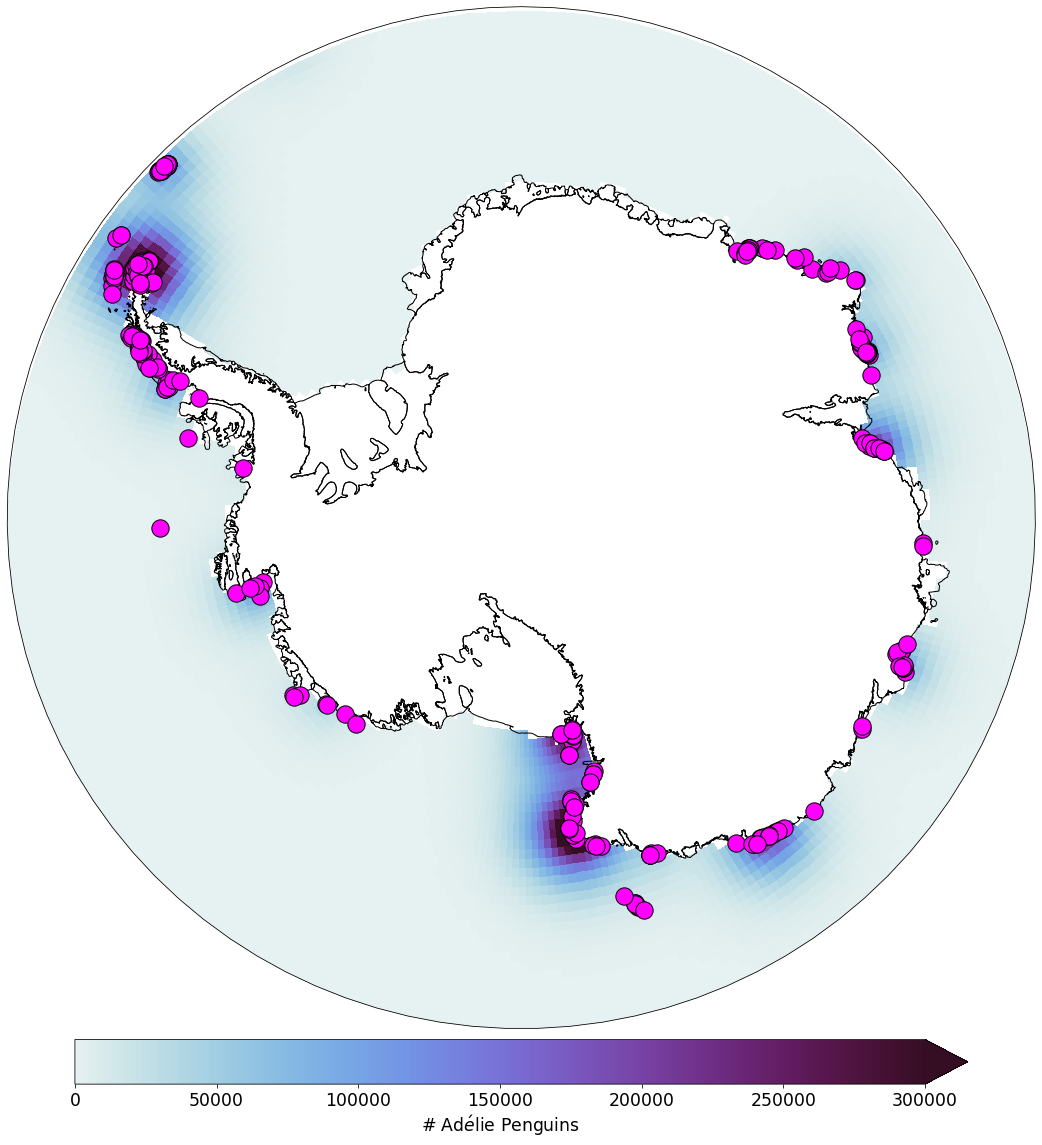

In [16]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot EP distance info
lon, lat, field = utils.adjust_pop_grid(lons,lats,total_penguins)
this=ax.pcolormesh(lon,lat,
                   field,
                   cmap=cmap_in,                      
                   vmax=vmax_in, vmin=vmin_in,
                   transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'# Ad$\acute{e}$lie Penguins',fontsize='xx-large')

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot Colony Locations - sizes vary by colony size
this1=ax.scatter(data_col_lon,data_col_lat,
                 color='magenta', edgecolor='black', s=300,
                 zorder = 100,
                 transform=ccrs.PlateCarree())

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)